# Article Naïve Bayes Classification
- *Author*: Juan Cabanela
- *Start Date*: December 2, 2021

### Requirements

Requires the following python libraries:
- pandas
- numpy
- scikit-learn (sklearn)

This notebook applies the previously developed Naïve Bayes classifiers to the target article data for this project and saves the results.

### History
- **November 2, 2021**: First version of the code, it reads in the tokenized article data as well as the two NB classifiers we trained and then makes predictions based on those classifiers.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import pickle
from sklearn import naive_bayes, metrics

##
## Custom functions
##

# Print out report based on confusion matrix
def summary_stats(tn, fp, fn, tp, classifier_label):
    # Do some manual computations
    p = tp + fn  # Positives
    n = fp + tn  # Negatives

    print(f"Reported Confusion Matrix for '{classifier_label}' Binary NB classifier:")
    print(" Predicted    Positive      Negative")
    print("Actual")
    print(f"Positive    {tp:07d}(TP)   {fn:07d}(FN)   {p:07d}(P)")
    print(f"Negative    {fp:07d}(FP)   {tn:07d}(TN)   {n:07d}(N)\n")

    print(f"Reported Statistics for '{classifier_label}' Binary NB classifier:")
    accuracy = (tp + tn) / (p + n)
    err_rate = (fp + fn) / (p + n)
    precision = tp / (tp + fp)
    recall = tp / p
    specificity = tn / n
    Fscore = (2 * precision * recall) / (precision + recall)

    print(f"  Accuracy (TP+TN)/P+N =\t{accuracy:0.5f}")
    print(f"Error Rate (FP+FN)/P+N =\t{err_rate:0.5f}")
    print(f"  Precision TP/(TP+FP) =\t{precision:0.5f}")
    print(f"           Recall TP/P =\t{recall:0.5f}")
    print(f"      Specificity TN/N =\t{specificity:0.5f}")
    print(f"               F-Score =\t{Fscore:0.5f}")

def multiclass_summary_stats(conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support):
    print(f"Reported Classification Statistics for Multiclass NB Classifier")
    print(f"{' ':12}  {'precision':>12}  {'recall':>12}  {'f1-score':>12}  {'support':>14}")

    # Get averages and standard deviations for labels
    label_avgprecision = np.average(label_precisions, axis=0)
    label_avgrecall = np.average(label_recalls, axis=0)
    label_avgf1 = np.average(label_f1s, axis=0)
    label_avgsupport = np.average(label_support, axis=0)
    label_stdprecision = np.std(label_precisions, axis=0)
    label_stdrecall = np.std(label_recalls, axis=0)
    label_stdf1 = np.std(label_f1s, axis=0)
    label_stdsupport = np.std(label_support, axis=0)
    total_support = np.sum(label_support,axis=1)
    for i, label in enumerate(labels):
        precision_str = f"{label_avgprecision[i]:04.3f}({label_stdprecision[i]:04.3f})"
        recall_str = f"{label_avgrecall[i]:04.3f}({label_stdrecall[i]:04.3f})"
        f1_str = f"{label_avgf1[i]:04.3f}({label_stdf1[i]:04.3f})"
        support_str = f"{label_avgsupport[i]:6.1f}({label_stdsupport[i]:.1f})"
        print(f"{label:12}  {precision_str:12}  {recall_str:12}  {f1_str:12}  {support_str:>14}")
    print("")

    # Get global averages and standard deviations
    avg_totsupport = np.average(total_support, axis=0)
    std_totsupport = np.std(total_support, axis=0)
    avg_accuracy = np.average(accuracies, axis=0)
    std_accuracy = np.std(accuracies, axis=0)
    avg_macrorecall = np.average(recalls, axis=0)
    std_macrorecall = np.std(recalls, axis=0)
    avg_macroprec = np.average(precisions, axis=0)
    std_macroprec = np.std(precisions, axis=0)
    avg_macrof1 = np.average(f1s, axis=0)
    std_macrof1 = np.std(f1s, axis=0)

    totsupport_str = f"{avg_totsupport:6.1f}({std_totsupport:.1f})"
    accuracy_str = f"{avg_accuracy:04.3f}({std_accuracy:04.3f})"
    macro_recall_str = f"{avg_macrorecall:04.3f}({avg_macrorecall:04.3f})"
    macro_prec_str = f"{avg_macroprec:04.3f}({std_macroprec:04.3f})"
    macro_f1_str = f"{avg_macrof1:04.3f}({std_macrof1:04.3f})"

    print(f"{'accuracy':12}  {' ':12}  {' ':12}  {accuracy_str:12}  {totsupport_str:>14}")
    print(f"{'macro':12}  {macro_prec_str:12}  {macro_recall_str:12}  {macro_f1_str:12}  {totsupport_str:>14}")

    # Adjust font sizes (copied from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
    size=20
    params = {'legend.fontsize': 'large',
            'axes.labelsize': size,
            'axes.titlesize': size,
            'xtick.labelsize': size*0.60,
            'ytick.labelsize': size*0.65,
            'axes.titlepad': 25}
    plt.rcParams.update(params)

    # Display average confusion matrix
    avg_conf_matrix = np.average(conf_matrices,axis=0)
    std_conf_matrix = np.std(conf_matrices,axis=0)
    sigma_conf_matrix = avg_conf_matrix/std_conf_matrix  # Computes sigma of how certain average (how different from zero)

    fig, ax = plt.subplots(figsize=(15, 15))
    disp = metrics.ConfusionMatrixDisplay(avg_conf_matrix, display_labels=labels)
    disp.plot(cmap='plasma', ax=ax)
    disp.ax_.set_title(f"Reported Average Confusion Matrix, Normalized to True Counts")

    # fig, ax = plt.subplots(figsize=(15, 15))
    # disp = metrics.ConfusionMatrixDisplay(std_conf_matrix, display_labels=labels)
    # disp.plot(cmap='plasma', ax=ax)
    # disp.ax_.set_title(f"Reported Standard Deviation of Confusion Matrix, Normalized to True Counts")

    # fig, ax = plt.subplots(figsize=(15, 15))
    # disp = metrics.ConfusionMatrixDisplay(sigma_conf_matrix, display_labels=labels)
    # disp.plot(cmap='plasma', ax=ax)
    # disp.ax_.set_title(f"Reported $\sigma$ of Confusion Matrix, Normalized to True Counts")

##
## Define constants
##
DEBUG = False

# Directory containing chunked data
data_dir = "../"
article_data = f"{data_dir}articles_fullcontext_cleaned.csv"
var_dir = "../Variables/"
tokenized_article_data = f"{var_dir}articles_fullcontext_tokenized_100000.p"


## Loading the Trained NB Classifiers

The previously trained NB Classifiers have been saved as pickle files and are reloaded here.

### First load the Binary NB Classifier

In [2]:
# Set up path to pickle file
clfnet_pickle_file = f"{var_dir}NBbinary_reliable.p"
clfnet_pickle_path = pathlib.Path(clfnet_pickle_file)

# If pickle file exists load it
if (clfnet_pickle_path.is_file()):
    print(f"Loading previously-built binary NB classifier (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    clf_network = pickle.load( open( clfnet_pickle_file, "rb" ) )

    # Load classifier from clf_network dictionary structure
    binary_clf = clf_network['clf']

    # Print stats on the loaded classifier
    summary_stats(clf_network['TN'], clf_network['FP'], clf_network['FN'], clf_network['TP'], 'reliable')
else:
    print(f"DO NOT PROCEED, could not load the binary NB classifier from {clfnet_pickle_file}")

Loading previously-built binary NB classifier (about 3.82 MB)
Reported Confusion Matrix for 'reliable' Binary NB classifier:
 Predicted    Positive      Negative
Actual
Positive    0342295(TP)   0041350(FN)   0383645(P)
Negative    0210521(FP)   0943294(TN)   1153815(N)

Reported Statistics for 'reliable' Binary NB classifier:
  Accuracy (TP+TN)/P+N =	0.83618
Error Rate (FP+FN)/P+N =	0.16382
  Precision TP/(TP+FP) =	0.61918
           Recall TP/P =	0.89222
      Specificity TN/N =	0.81754
               F-Score =	0.73104


### Second load the multiclass NB Classifier

Loading previously-built Multiclass classifier network (about 3.82 MB)
Reported Classification Statistics for Multiclass NB Classifier
                 precision        recall      f1-score         support
bias          0.548(0.062)  0.569(0.052)  0.557(0.051)   218306.6(0.5)
clickbait     0.516(0.193)  0.283(0.102)  0.363(0.130)    47335.4(0.5)
conspiracy    0.624(0.071)  0.533(0.077)  0.573(0.068)   166982.8(0.4)
fake          0.567(0.065)  0.519(0.025)  0.540(0.035)   175606.6(0.5)
hate          0.505(0.077)  0.200(0.057)  0.285(0.070)    25602.0(0.0)
junksci       0.454(0.037)  0.616(0.075)  0.521(0.047)    28509.2(0.4)
political     0.671(0.025)  0.540(0.170)  0.584(0.100)   330868.8(0.4)
reliable      0.595(0.065)  0.819(0.141)  0.685(0.084)   377892.4(0.5)
rumor         0.673(0.070)  0.800(0.046)  0.728(0.050)    95990.6(0.5)
satire        0.617(0.236)  0.183(0.116)  0.275(0.159)    22304.2(0.4)
unreliable    0.596(0.148)  0.275(0.245)  0.349(0.236)    48061.0(0.0)

accuracy    

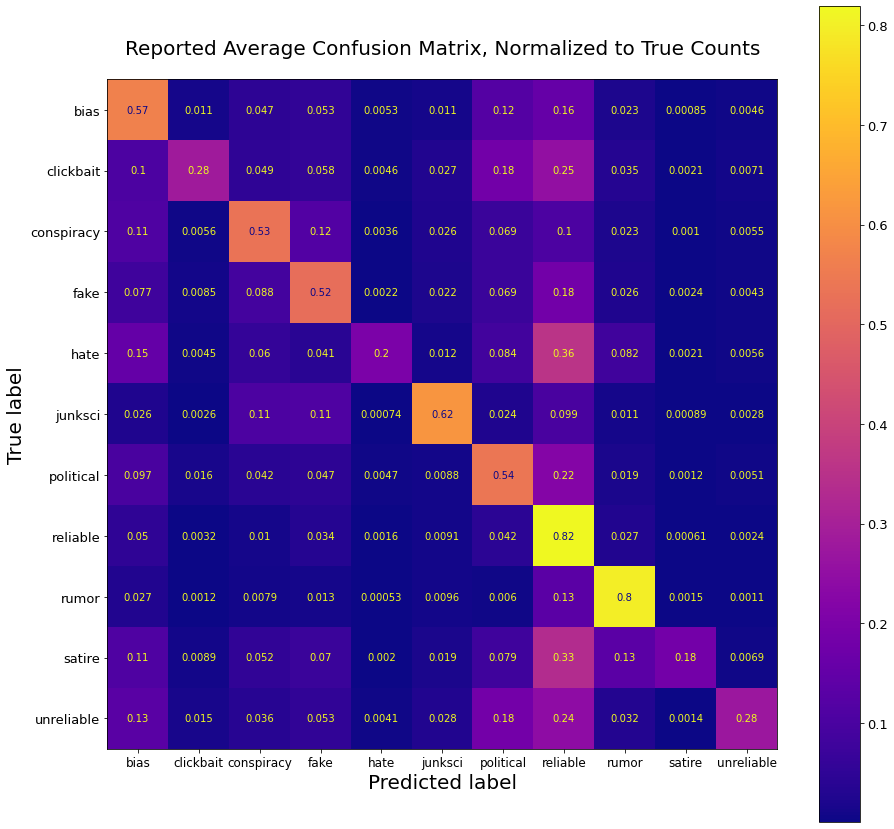

In [3]:
# Set up path to pickle file
multiclassclf_pickle_file = f"{var_dir}NB_Multiclass.p"
multiclassclf_pickle_path = pathlib.Path(multiclassclf_pickle_file)
multiclassstats_pickle_file = f"{var_dir}NB_Multiclass_stats.p"
multiclassstats_pickle_path = pathlib.Path(multiclassstats_pickle_file)

# If pickle files exist, load them
if (multiclassclf_pickle_path.is_file() & multiclassstats_pickle_path.is_file() ):
    print(f"Loading previously-built Multiclass classifier network (about {clfnet_pickle_path.stat().st_size/1024**2:0.2f} MB)")
    multiclass_clf = pickle.load( open( multiclassclf_pickle_path, "rb" ) )
    [conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support] = pickle.load( open( multiclassstats_pickle_path, "rb" ) )

    # Print stats for loaded classifier
    multiclass_summary_stats(conf_matrices, accuracies, recalls, precisions, f1s, labels, label_precisions, label_recalls, label_f1s, label_support)
else:
    print(f"DO NOT PROCEED, could not load the multiclass NB classifier from {clfnet_pickle_file}")

## Load Articles and Apply the Classifiers

Now we need to load the article data and see what the two classifiers predict.


In [4]:
# Number of words kept by TF-IDF tokenizer
words2keep = 100000

# Name of full cleaned target article datafile
fname_fullcontext_cleaned = f"{data_dir}articles_fullcontext_cleaned.csv"
articles_df = pd.read_csv(fname_fullcontext_cleaned)

# Name of articles tokenized content file
tokenized_pickle_file = f"{var_dir}articles_fullcontext_tokenized_{words2keep:06d}.p"
tokenized_pickle_path = pathlib.Path(tokenized_pickle_file)

if ( tokenized_pickle_path.is_file() ):
    tokenized_content = pickle.load( open( tokenized_pickle_path, "rb" ) )
else:
    print(f"Unable to open tokenized content pickle file {tokenized_pickle_file}")

In [5]:
# Process the data through the binary classifier
predictions_binaryNB = binary_clf.predict(tokenized_content)
articles_df['Reliable_Predict']= predictions_binaryNB.tolist()

# Process the data through the multiclass classifier
predictions_multiclassNB = multiclass_clf.predict(tokenized_content)
articles_df['MC_Predict']= predictions_multiclassNB.tolist()
articles_df['MC_Predict']= articles_df['MC_Predict'].map(dict(enumerate(labels)))

# Rearrange columns
cols = articles_df.columns.tolist()
cols = cols[-2:]+cols[:-2]

# Write articles to disk
classified_articles_csv = f"articles_classified.csv"
print(f"- Writing classified articles data to {classified_articles_csv}")
articles_df[cols].to_csv(classified_articles_csv, index=False)



- Writing classified articles data to articles_classified.csv


In [6]:
articles_df

,domain,story_label,title,content,Reliable_Predict,MC_Predict
0,cnn.com,House Speaker,Pelosi: 'Let us work,Story Highlights • Pelosi accepts gavel as fir...,False,political
1,cnn.com,Obama Elected,Obama: 'This is your,"(CNN) -- Barack Obama told supporters that ""ch...",False,political
2,cnn.com,Hurricane Katrina,New Orleans braces for monster,New Orleans braces for monster hurricane Cresc...,True,reliable
3,cnn.com,Japan Earthquake & Tsunamis,"Widespread destruction from Japan earthquake,",Editor's Note: Read live blogging of the Japan...,False,reliable
4,cnn.com,BP Oil Spill,"As oil spill nears Gulf Coast, experts issue dire","Venice, Louisiana (CNN) -- Gulf coast resident...",True,reliable
...,...,...,...,...,...,...
78,wsj.com,Obama Elected,Obama Sweeps to Historic,WASHINGTON -- Sen. Barack Obama was elected th...,False,political
79,wsj.com,London Olympics,Last Call in,"Another summer, another Summer Olympics. It's ...",True,reliable
80,wsj.com,Boston Marathon Bombings,Deadly Blasts Rock,BOSTON—Two deadly explosions ripped through a ...,True,reliable
81,wsj.com,Russia Invades Ukraine,"Ukraine Accuses Russia of Invasion, West to Co...",Kiev and its Western backers accused Moscow of...,False,bias
